In [20]:
import os
import glob

import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from rdkit import DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator

import matplotlib.pyplot as plt

### 1. Confusion Matrix on test data (each classification GCN)

Please take into account I saved the names of the files with 'validation' but I meant them as 'testing'. 

In [11]:
def plot_confusion_matrix_with_accuracy(actual, predicted):
    """
    Plots a confusion matrix and annotates it with the accuracy score.

    Parameters:
    actual (pd.Series or list): True labels.
    predicted (pd.Series or list): Predicted labels.
    """
    # Calculate accuracy
    accuracy = accuracy_score(actual, predicted)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(actual, predicted)
    
    # Annotate accuracy on the plot
    plt.text(0.5, 1.1, f'Accuracy: {accuracy:.2%}', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=12, color='black')
    
    # Show the plot
    plt.show()

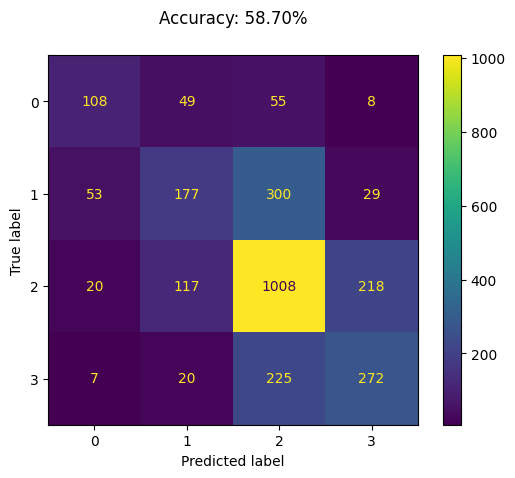

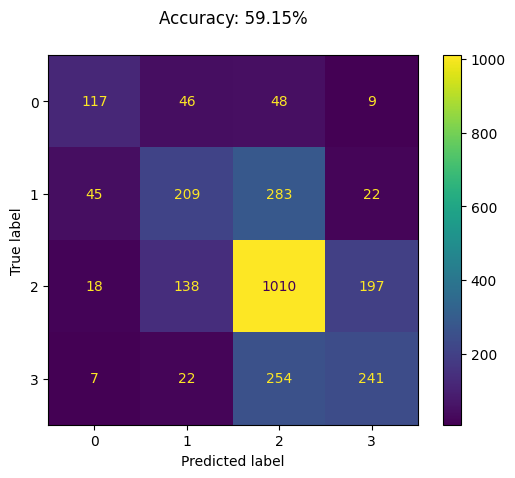

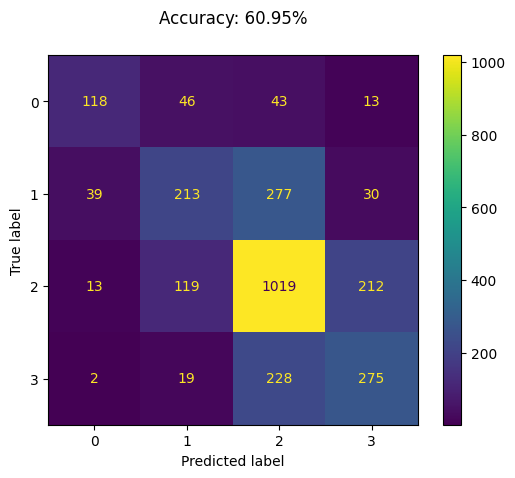

In [12]:
def concatenate_prediction_files(folder_path, file_patt):
    file_pattern = os.path.join(folder_path, file_patt)
    files = glob.glob(file_pattern)
    
    for file in files:
        df = pd.read_csv(file)
        plot_confusion_matrix_with_accuracy(df['actual_epa'], df['predicted_epa'])

# Usage
folder_path = '../../data/replication_gcn'
all_data = concatenate_prediction_files(folder_path, "classification_gcn_*_stratified_validation.csv")

### 2. Confusion Matrix from Classiciation on test data (Voting system)

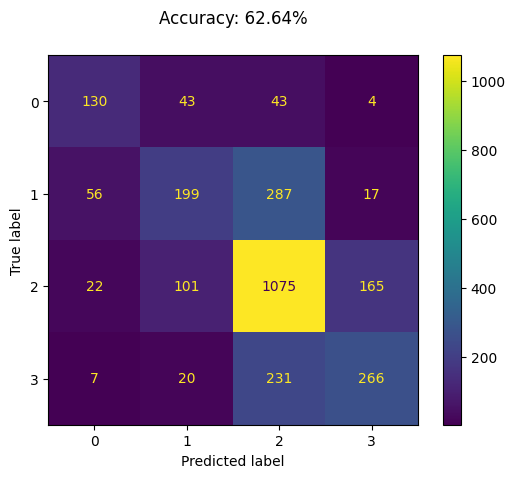

In [13]:
def concatenate_prediction_files(folder_path, file_patt):
    file_pattern = os.path.join(folder_path, file_patt)
    files = glob.glob(file_pattern)
    
    epa_columns = ['actual_epa', 'predicted_epa']

    all_data = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
    all_data = all_data.groupby('smiles').agg(
        {**{col: lambda x: x.mode()[0] if not x.mode().empty else None for col in epa_columns}}  # Mode for EPA columns
    ).reset_index()

    return all_data

# Usage
folder_path = '../../data/replication_gcn'
class_strat_data = concatenate_prediction_files(folder_path, "classification_gcn_*_stratified_validation.csv")

plot_confusion_matrix_with_accuracy(class_strat_data['actual_epa'], class_strat_data['predicted_epa'])

### 3. Missclassification across folds

In [14]:
class_strat_results_training = pd.read_csv('../../data/replication_gcn/classification_gcn_1727_3792_64_stratified_training.csv')

In [25]:
def count_misclassifications(df):
    # Identify misclassified rows
    misclassified = df[df['actual_epa'] != df['prediction_epa']]
    
    # Count misclassifications per unique SMILES and sort in descending order
    misclassification_counts = misclassified['smiles'].value_counts().sort_values(ascending=False)
    misclassification_df = misclassification_counts.reset_index()
    misclassification_df.columns = ['smiles', 'misclassification_count']
    
    return misclassification_df

#### 3.1 Find always missclassified

In [45]:
all_miss_class_strat = count_misclassifications(class_strat_results_training)
all_miss_class_strat = all_miss_class_strat[all_miss_class_strat['misclassification_count'] > 2]
print('Total components always missclassified:',len(all_miss_class_strat), 'of a total of', len(class_strat_results_training))
all_miss_class_strat.head()

Total components always missclassified: 2002 of a total of 31989


,smiles,misclassification_count
0,NC(=O)c1ccc([N+](=O)[O-])cc1,3
1,Clc1ccc(OCOc2ccc(Cl)cc2)cc1,3
2,N#C[SeH],3
3,N#CS,3
4,N#Cc1ccc([N+](=O)[O-])cc1,3


This result is a good argument for a voting system

#### 3.2 Check PFAS in the missclassified

In [32]:
full_data = pd.read_csv('../../data/full_dataset.csv')
full_data = full_data[['smiles','is_pfas_like','is_pfas','epa']]

In [33]:
arePFAS = all_miss_class_strat.merge(full_data, on=['smiles'], how='left')

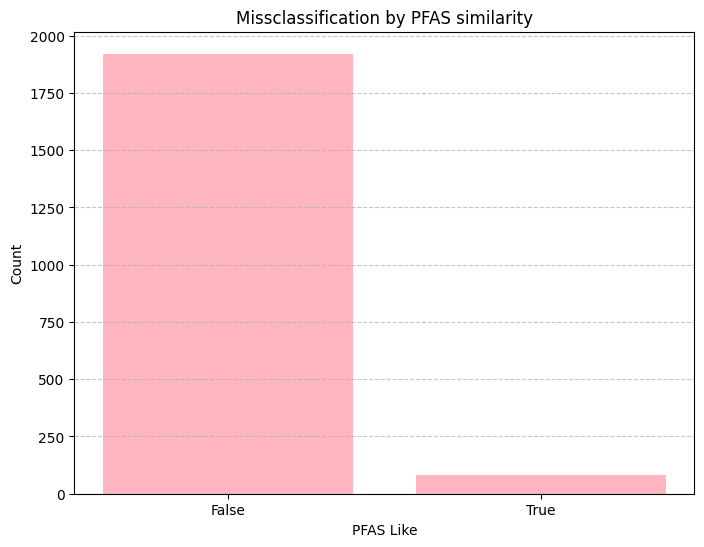

In [56]:
likePFAS_counts = arePFAS['is_pfas_like'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(likePFAS_counts.index.astype(str), likePFAS_counts.values, color='lightpink')
plt.xlabel('PFAS Like')
plt.ylabel('Count')
plt.title('Missclassification by PFAS similarity')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

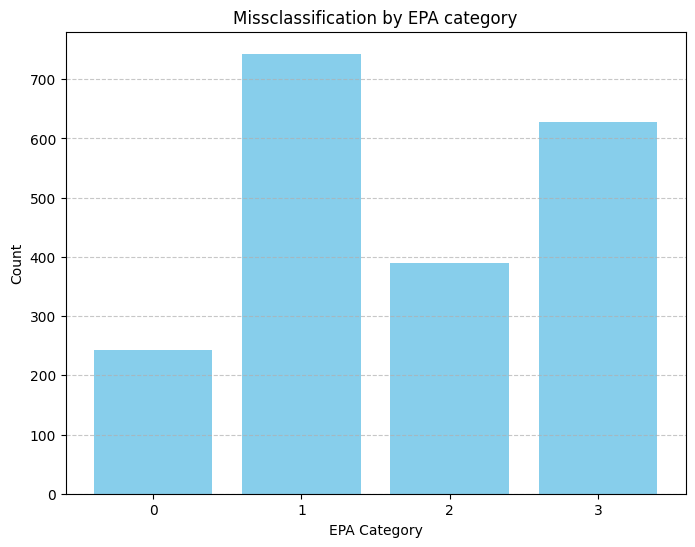

In [55]:
epa_counts = arePFAS['epa'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(epa_counts.index, epa_counts.values, color='skyblue')
plt.xlabel('EPA Category')
plt.ylabel('Count')
plt.title('Missclassification by EPA category')

plt.gca().xaxis.get_major_locator().set_params(integer=True)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4. Tanimoto similarity (similar molecules) - validation vs training datasets

In [ ]:
# http://www.dalkescientific.com/writings/diary/archive/2020/10/02/using_rdkit_bulktanimotosimilarity.html
# Convert SMILES to fingerprints
test_smiles = class_strat_data['smiles'].unique()
train_smiles = class_strat_results_training['smiles'].unique()

# Morgan generator
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)

test_fps = [morgan_generator.GetCountFingerprint(AllChem.MolFromSmiles(smiles)) for smiles in test_smiles]
train_fps = [morgan_generator.GetCountFingerprint(AllChem.MolFromSmiles(smiles)) for smiles in train_smiles]

# Prepare to collect results
results = []

for test_smiles, test_fp in zip(test_smiles, test_fps):
    # Calculate similarity to all training fingerprints
    similarities = DataStructs.BulkTanimotoSimilarity(test_fp, train_fps)
    
    # Sort similarities in descending order and select the third highest score
    sorted_similarities = sorted(similarities, reverse=True)
    
    # Check if there are at least three similarities, otherwise take the maximum
    third_highest_similarity = sorted_similarities[2] if len(sorted_similarities) >= 3 else max(sorted_similarities)
    
    # Append result
    results.append({'test_smiles': test_smiles, 'third_highest_similarity': third_highest_similarity})

# Convert results to a DataFrame for easier viewing and manipulation
results_df = pd.DataFrame(results)

#### 4.1 Correlation of molecule similarity and error

In [ ]:
# Data with the preditions of NegLog on test data
data = pd.read_csv()
data['distance'] = abs(data['actual_neglog'] - data['predicted_neglog'])
merged_smiles = pd.merge(results_df, data, on='smiles')

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_smiles['third_highest_similarity'], merged_smiles['distance'], alpha=0.7, color='blue')
plt.title('Correlation between Tanimoto Similarity and Distance')
plt.xlabel('Third-Highest Tanimoto Similarity')
plt.ylabel('Distance (|actual_neglog - predicted_neglog|)')
plt.grid(True)
plt.show()